<a href="https://colab.research.google.com/github/ianbbbanian5476/THU-Python-class/blob/main/%E4%BA%BA%E5%B7%A5%E7%A0%B4%E6%9C%9F%E4%B8%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# 讀取資料
data1 = pd.read_csv('/content/drive/MyDrive/人工智慧與資訊安全_小組/兩類流量/兩類流量/flow1_v1.csv')
data2 = pd.read_csv('/content/drive/MyDrive/人工智慧與資訊安全_小組/兩類流量/兩類流量/flow2_v1.csv')

# 為兩個資料集新增標籤欄位
data1['label'] = 0  # flow1_v1.csv 的標籤為 0
data2['label'] = 1  # flow2_v1.csv 的標籤為 1

# 合併兩組資料
data = pd.concat([data1, data2], ignore_index=True)

# 隨機打亂資料
data = data.sample(frac=1).reset_index(drop=True)

# 檢查原始資料是否有空值
print("原始資料是否有空值:", data.isnull().sum().sum())
data.fillna(data.median(), inplace=True)
print("原始資料是否有空值:", data.isnull().sum().sum())

# 上採樣類別 1
class_0 = data[data['label'] == 0]
class_1 = data[data['label'] == 1]

# 假設類別 1 數據較少，進行上採樣
class_1_upsampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)

# 合併平衡數據
data_balanced = pd.concat([class_0, class_1_upsampled])

# 隨機打亂平衡後的數據
data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)

# 將資料切割為 50 到 100 份
split_count = np.random.randint(50, 101)
split_data = np.array_split(data, split_count)

# 重新合併資料
data = pd.concat(split_data, ignore_index=True)


原始資料是否有空值: 229988
原始資料是否有空值: 0


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 假設 data 包含特徵及標籤
X = data.drop('label', axis=1)  # 假設 'label' 為標籤欄位
y = data['label']

# 以 80/20 比例分割訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 重置標籤索引
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 確保標籤是整數類型
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# 檢查標籤唯一值
print("y_train unique values:", np.unique(y_train))
print("y_test unique values:", np.unique(y_test))

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 檢查並填充標準化數據中的空值
X_train_scaled = pd.DataFrame(X_train_scaled).fillna(X_train.mean()).values
X_test_scaled = pd.DataFrame(X_test_scaled).fillna(X_test.mean()).values

# print("X_train_reshaped 是否有空值:", np.any(np.isnan(X_train_reshaped)))
# print("y_train 是否有空值:", np.any(np.isnan(y_train)))

# 重新格式化資料以適應 CNN
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


y_train unique values: [0 1]
y_test unique values: [0 1]


In [ ]:
# 測試不同的學習率
learning_rates = [0.1, 0.2, 0.3, 0.4]
accuracy_list = []
recall_list = []
f1_list = []

for lr in learning_rates:
    # CNN 模型
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # 編譯模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    # 計算類別權重
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # 訓練模型
    model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=20, batch_size=32, class_weight=class_weights, verbose=1)

# 預測測試集
y_pred = (model.predict(X_test_reshaped) > 0.5).astype(int)

# 計算混淆矩陣和分類報告
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# 保存準確率、召回率和 F1 分數
accuracy_list.append(report['accuracy'])
recall_list.append(report['1']['recall'])
f1_list.append(report['1']['f1-score'])


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8738 - loss: 19.1336 - val_accuracy: 0.9990 - val_loss: 0.0264
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9838 - loss: 11.1439 - val_accuracy: 0.9990 - val_loss: 0.0478
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9881 - loss: 54.4371 - val_accuracy: 0.9990 - val_loss: 26.2229
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9941 - loss: 206.3941 - val_accuracy: 0.9990 - val_loss: 8.9691
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9881 - loss: 77.4305 - val_accuracy: 0.9990 - val_loss: 27.8391
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9958 - loss: 46.9545 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9972 - loss: 12.5169 - val_accuracy: 0.9981 - val_loss: 1.2347
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9900 - loss: 78

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

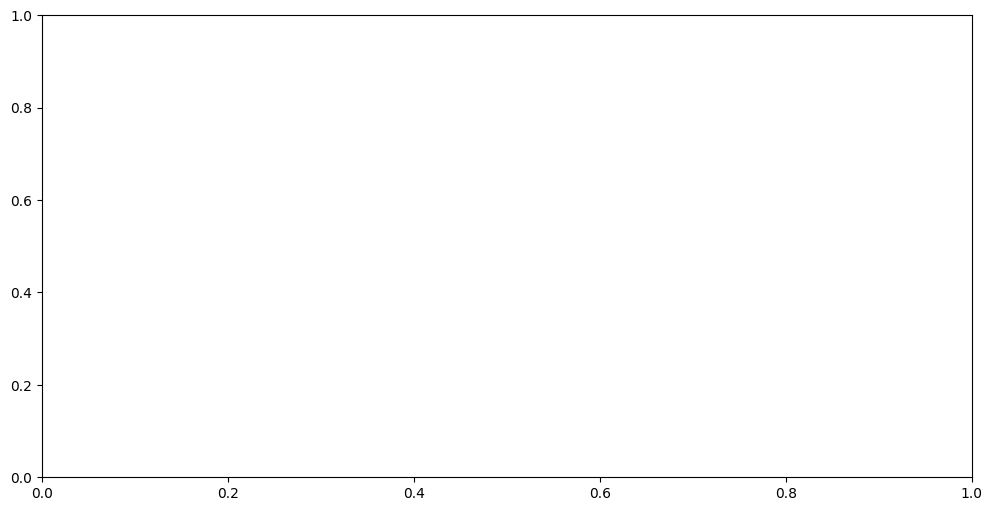

In [ ]:
# 繪製不同學習率下的性能曲線
plt.figure(figsize=(12, 6))
plt.plot(learning_rates, accuracy_list, label='Accuracy', marker='o')
plt.plot(learning_rates, recall_list, label='Recall', marker='o')
plt.plot(learning_rates, f1_list, label='F1 Score', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Metrics')
plt.title('Metrics vs Learning Rate')
plt.legend()
plt.show()

# 繪製混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# 定義 CNN 模型
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 編譯模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 計算類別權重
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

# 訓練模型
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=100, batch_size=32, class_weight=class_weights, verbose=1)


Class Weights: {0: 1.0343889163780307, 1: 0.9678240740740741}
Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9544 - loss: 0.1283 - val_accuracy: 1.0000 - val_loss: 5.1207e-04
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 2.7120e-04
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9999 - loss: 5.1905e-04 - val_accuracy: 1.0000 - val_loss: 8.2915e-05
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 1.0000 - loss: 1.0857e-04 - val_accuracy: 1.0000 - val_loss: 2.5322e-05
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 1.0000 - loss: 4.7821e-05 - val_accuracy: 1.0000 - val_loss: 1.1969e-05
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 1.0000 - loss: 3.3221e-05 - val_accuracy: 1.0000 - val_loss: 7.8380e-06
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 1.0000 - val_l

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8984 - loss: 27.5541 - val_accuracy: 0.9990 - val_loss: 4.5946
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9588 - loss: 2.7832 - val_accuracy: 0.9990 - val_loss: 0.5543
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9679 - loss: 0.8247 - val_accuracy: 0.9713 - val_loss: 1.0169
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9211 - loss: 1.2344 - val_accuracy: 0.9359 - val_loss: 1.0854
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9474 - loss: 0.7416 - val_accuracy: 0.9809 - val_loss: 0.8417
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9227 - loss: 1.0796 - val_accuracy: 0.9962 - val_loss: 0.4688
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9201 - loss: 0.6285 - val_accuracy: 0.9990 - val_loss: 0.3865
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9158 - loss: 0.6736 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5124 - loss: 5.4402 - val_accuracy: 0.5172 - val_loss: 0.6970
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4979 - loss: 0.6963 - val_accuracy: 0.5172 - val_loss: 0.6936
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5061 - loss: 0.8514 - val_accuracy: 0.4828 - val_loss: 0.6971
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4987 - loss: 1.1123 - val_accuracy: 0.5172 - val_loss: 0.8443
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5172 - loss: 0.7313 - val_accuracy: 0.5172 - val_loss: 0.6938
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5081 - loss: 0.7384 - val_accuracy: 0.5172 - val_loss: 1.4197
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5092 - loss: 1.3926 - val_accuracy: 0.4828 - val_loss: 1.3214
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5060 - loss: 1.3191 - val_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5044 - loss: 11.7666 - val_accuracy: 0.5172 - val_loss: 0.6945
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4915 - loss: 0.6993 - val_accuracy: 0.5172 - val_loss: 0.6927
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5006 - loss: 0.6979 - val_accuracy: 0.4828 - val_loss: 0.6970
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5136 - loss: 0.6943 - val_accuracy: 0.5172 - val_loss: 0.6934
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5276 - loss: 1.5228 - val_accuracy: 0.5182 - val_loss: 59.1535
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5728 - loss: 2819.1211 - val_accuracy: 0.9847 - val_loss: 9746.4307
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7813 - loss: 29947.7012 - val_accuracy: 0.7839 - val_loss: 8173.6509
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6467 - loss: 11889.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5128 - loss: 17.2321 - val_accuracy: 0.4828 - val_loss: 0.6965
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5293 - loss: 0.6958 - val_accuracy: 0.4828 - val_loss: 0.6995
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.4874 - loss: 0.7019 - val_accuracy: 0.4828 - val_loss: 0.7039
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4929 - loss: 0.6988 - val_accuracy: 0.5172 - val_loss: 0.6927
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5150 - loss: 0.7023 - val_accuracy: 0.5172 - val_loss: 0.6928
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4979 - loss: 0.7056 - val_accuracy: 0.5172 - val_loss: 0.7690
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5232 - loss: 0.8238 - val_accuracy: 0.4828 - val_loss: 0.7914
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5259 - loss: 0.8182 - val_accurac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


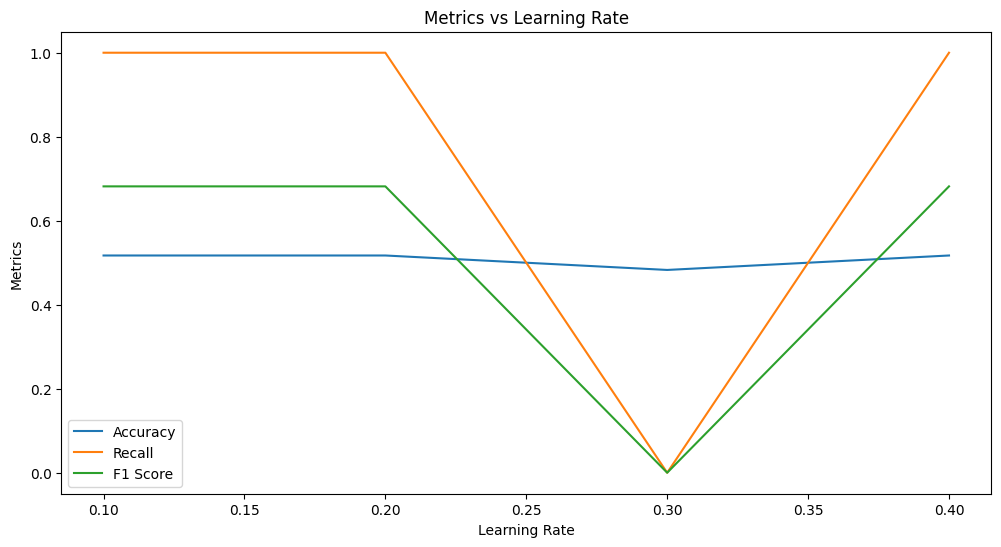

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

lrs = [0.1, 0.2, 0.3, 0.4]
accuracy_list, recall_list, f1_list = [], [], []

for lr in lrs:
    # 重新設定模型，使用不同的學習率
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=100, batch_size=32, verbose=1)

    # 預測結果
    y_pred = (model.predict(X_test_reshaped) > 0.5).astype(int)

    # 混淆矩陣與分類報告
    print(confusion_matrix(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)

    # 儲存指標
    accuracy_list.append(report['accuracy'])
    recall_list.append(report['1']['recall'])  # 假設 '1' 為攻擊類別
    f1_list.append(report['1']['f1-score'])

# 繪製曲線圖
plt.figure(figsize=(12, 6))
plt.plot(lrs, accuracy_list, label='Accuracy')
plt.plot(lrs, recall_list, label='Recall')
plt.plot(lrs, f1_list, label='F1 Score')
plt.xlabel('Learning Rate')
plt.ylabel('Metrics')
plt.legend()
plt.title('Metrics vs Learning Rate')
plt.show()
